# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Final

**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, May 12th, 2018 at 11:59am

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

# Q1: GLMs with correlation

In Homework 10 you examined the effects of educational attainment and gender on the probability that an indivudal would earn more than $50K per year. However, even the models in the solutions (see Canvas) didn't achieve a perfect fit. Perhaps there was something missing?

## The dataset: A Study of Census Data

In this problem, we are reprising our investigation into the data from the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the UCI Machine Learning Repository).

We'll again want to aggregate the dataset into seven different categories. The categories we wish to consider are:

- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters
- Doctorate
- Some or no high school 

Note that we had to combine some of the existing education categories in your dataframe. For each category, we kept track of a count of the number of males and females who make above (and resp. below) $50k

We provide the code below so that all students begin with the same data structure, names, and global parameters.

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('census_data.csv')
df.head()

cat_1 = ['11th', '7th-8th', '9th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th']
cat_2 = ['HS-grad']
cat_3 = ['Some-college', 'Assoc-acdm']
cat_4 = ['Assoc-voc', 'Prof-school']
cat_5 = ['Bachelors']
cat_6 = ['Masters']
cat_7 = ['Doctorate']

labels = ["Some HS", "HS Grad", "Some College", "Prof School", "Bachelors", "Masters", "Doctorate"]

categories = [cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7]
dataset = []
i = 1
for cat in categories:
    filtered = df[df['edu'].isin(cat)]
    dataset.append((i, 0, len(filtered[filtered['sex'] == 'Female']), len(filtered[(filtered['sex'] == 'Female') & (filtered['earning'] == '<=50K')]), len(filtered[(filtered['sex'] == 'Female') & (filtered['earning'] == '>50K')])))
    dataset.append((i, 1, len(filtered[filtered['sex'] == 'Male']), len(filtered[(filtered['sex'] == 'Male') & (filtered['earning'] == '<=50K')]), len(filtered[(filtered['sex'] == 'Male') & (filtered['earning'] == '>50K')])))
    i += 1
dataset = np.array(dataset)
dataset = pd.DataFrame(dataset, columns=['category', 'sex', 'total', '<=50', '>50'])
dataset['category'] = dataset['category']-1 #zero indexing
dataset

,category,sex,total,<=50,>50
0,0,0,1321,1298,23
1,0,1,2932,2711,221
2,1,0,3390,3164,226
3,1,1,7111,5662,1449
4,2,0,3227,2974,253
5,2,1,5131,3732,1399
6,3,0,592,483,109
7,3,1,1366,691,675
8,4,0,1619,1280,339
9,4,1,3736,1854,1882


## Part A: Model 1

In Chapter 13.2 McElreath iterates on his model for the UCB admissions data. (See the attached PDF of that section. We have included pdfs of excerpts from McElreath sections 10.1.3 and 13.2)

**A1**: Implement the upgraded model from section 13.2.1 on the income data. You may refer to Osvaldo Martin's pymc3 implementation of Statistical Rethinking if needed.

**Answer:** Let's follow the HW10 first and build a similar model (edu_A1).

In [3]:
x = dataset['sex'].values
n = dataset['total'].values
y_obs = dataset['>50'].values
# partially copied from HW10 solution
with pm.Model() as edu_A1:
    sigma = pm.HalfCauchy('sigma',beta=2)
    alpha = pm.Normal('alpha',mu=0,sd=10)
    beta_m = pm.Normal('beta_m',mu=0,sd=1)
    alpha_edu = pm.Normal('alpha_edu', mu=alpha, sd=sigma, shape=7)
    p = pm.Deterministic('p', pm.math.invlogit(alpha_edu[np.arange(14)//2] + beta_m * x))
    y = pm.Binomial('y_obs', p=p, n=n, observed=y_obs)

**A2**: You will notice here that the $\alpha$s at different income levels are pooled

1. What criterion do you use to tell if full, partial, or no pooling is appropriate to the given data? 
2. Which type of pooling is implemented here. Why is it most appropriate to our income data?

**Answer:**
1.
No pooling will have a lot of parameters (overfit in small dataset) and we assume the parameters to estimate are independent. Therefore, for independent parameters and large dataset, no pooling is appropriate. 

Full pooling is another extreme where we assume the parameters are all same (i.e. only one parameter in the problem). When we have knowledge that all parameters should be same (for example, in repeated experiments with same conditions), we should use full pooling.

Partial pooling is where we suppose parameters are drawn from a single "population distribution". This can reduce the number of parameters compared to no pooling and provide the ability to capture variations in the samples. Partial pooling is appropriate for problem somehow in between of no pooling and full pooling.

2.
The type of pooling implemented here is **partial pooling**. partial pooling is most appropriate because intuitively $\alpha$s for different education level are different and might have some dependencies (for example, any $\alpha$ shouldn't differ too much from other $\alpha$s). In addition, our dataset is pretty small, using no pooling will likely to result in an overfit model.

**A3**: Sample from the model's posterior and comment on the quality of the samples obtained, examining at least two of the diagnostics discussed in class.

\[Sampling this model took 2 minutes and 30 seconds per chain (~80 it/s) on a VM running on old hardware.\]

**Answer:** Let's do sampling first.

In [4]:
with edu_A1:
    sample_A1=pm.sample(10000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_edu, beta_m, alpha, sigma_log__]
100%|██████████| 11000/11000 [00:30<00:00, 356.24it/s]


Now, let's check the convergence. First, I plot the trace plot and the autocorrelation plot. For autocorrelation plot, I only plotted the alphas and beta since there are too many parameters.

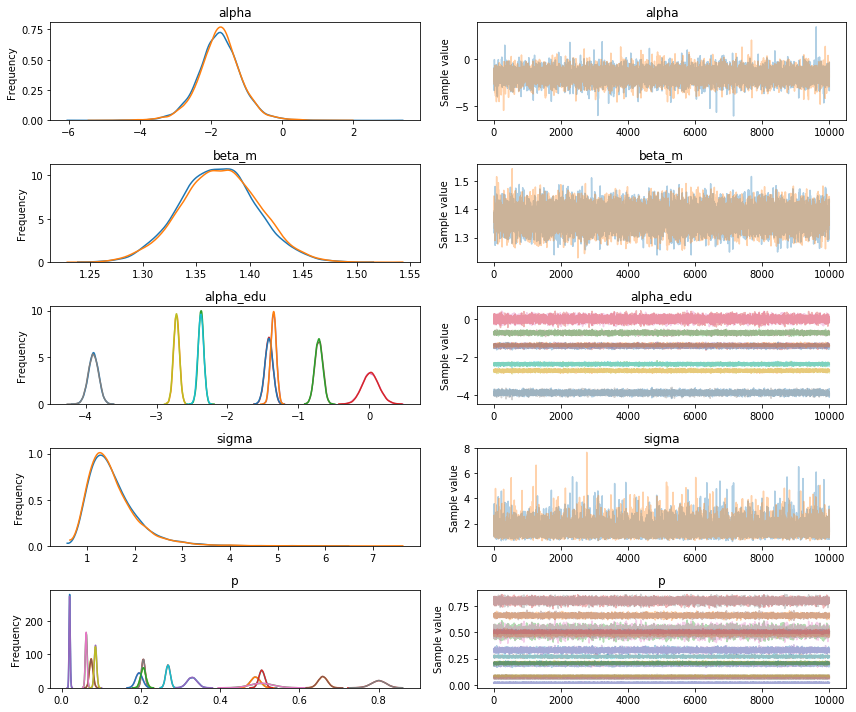

In [5]:
pm.traceplot(sample_A1);

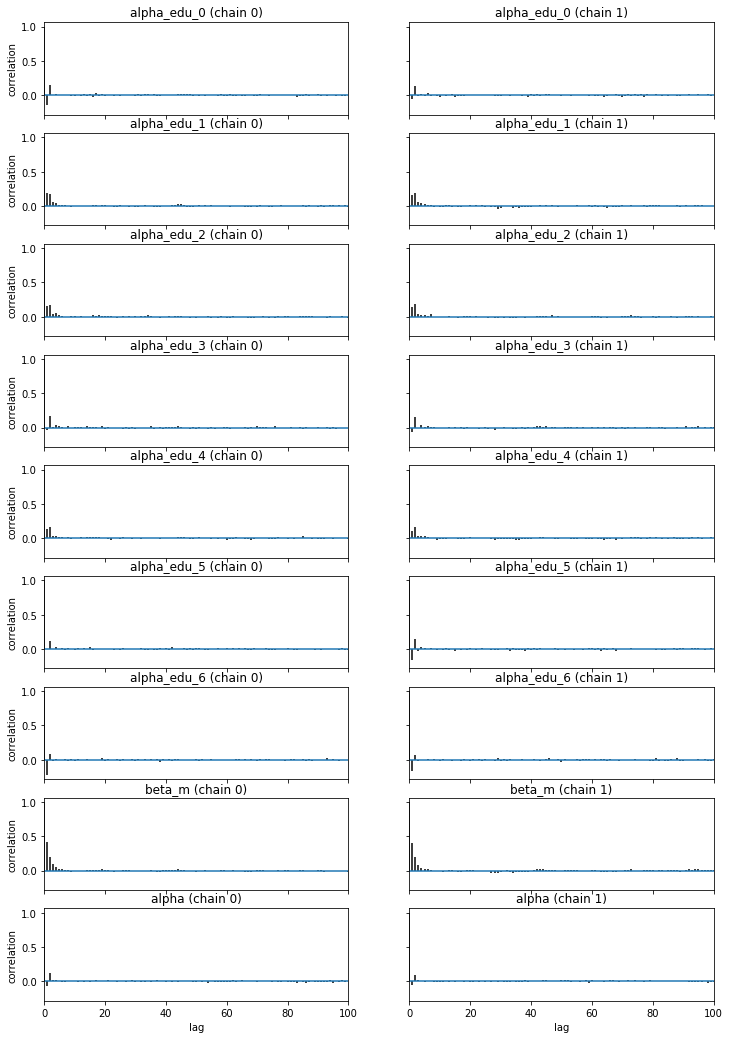

In [6]:
pm.autocorrplot(sample_A1,varnames=['alpha_edu','beta_m','alpha']);

Traceplot looks OK and all autocorrelations die by around lag 10. So convergence is OK. Let's further check Gelman statistic and the number of effective samples.

In [7]:
pm.diagnostics.gelman_rubin(sample_A1)

{'alpha': 0.9999502701966131,
 'alpha_edu': array([1.00016804, 1.00017051, 1.00022152, 1.00006269, 1.00026885,
        1.00025074, 0.99995141]),
 'beta_m': 1.000361295125951,
 'p': array([1.00014679, 0.99997378, 1.00015976, 0.99996956, 1.00020268,
        0.99995557, 1.0000554 , 0.99995823, 1.00026679, 0.99995009,
        1.0002544 , 0.99997322, 0.99995148, 0.9999733 ]),
 'sigma': 0.9999534132672573}

In [8]:
pm.diagnostics.effective_n(sample_A1)

{'alpha': 17421.0,
 'alpha_edu': array([16831.,  9973., 10298., 14719., 11059., 16805., 20000.]),
 'beta_m': 7687.0,
 'p': array([16901., 20000.,  9975., 20000., 10320., 20000., 14751., 20000.,
        11059., 20000., 16804., 20000., 20000., 20000.]),
 'sigma': 13546.0}

Our Gelman statistic is in a reasonable range (i.e. < 1.2) an our number of effective samples > 20% so the quality of sample is OK.

**A4**: Use the code below to plot the amount of shrinkage in our model. Think carefully about what quantity in the dataset and in the posterior you ought to compare. You should see minimal shrinkage in all categories except the last one.

In [9]:
def shrinkage_plot(observed_log_odds, posterior_means, posterior_sds):
    """
    observed_log_odds - an entry for each category giving the actual log-odds observed log(P(>50K)/(1-P(>50K)))
    posterior_means - an entry for each category giving the mean of the posterior distribution
    posterior_sds - an entry for each category giving the SD of the posterior distribution
    """
    plt.scatter(range(len(observed_log_odds)),observed_log_odds, label="Observed Log Odds", color='orange')
    plt.errorbar(range(len(posterior_means)), posterior_means, yerr = 2*posterior_sds, fmt='o', label="Posterior for Log Odds\n(mean and 2 SDs)",)
    plt.legend()
    plt.xlabel("Education Category")

**Answer:** As suggested in office hour, I plot seperate plots for male and female.

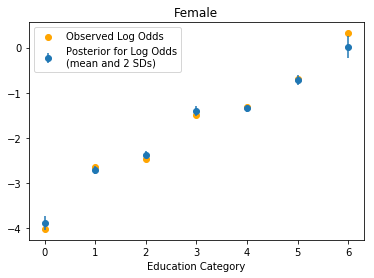

In [10]:
def srk_plot(df,trace,male):
    df_new = df
    df_new['50kratio'] = df_new['>50']/df_new['total']
    p_obs = df_new.loc[df_new['sex']==male,'50kratio'].values
    p_obs_logit = np.log(p_obs / (1-p_obs))
    p_posterior = trace.p[:,np.arange(7)*2+male]
    p_posterior_logit = np.log(p_posterior / (1-p_posterior))
    shrinkage_plot(p_obs_logit,p_posterior_logit.mean(axis=0),p_posterior_logit.std(axis=0))
srk_plot(dataset,sample_A1,0)
plt.title('Female');

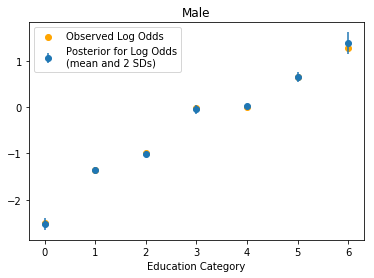

In [11]:
srk_plot(dataset,sample_A1,1)
plt.title('Male');

**A5**: McElreath's new model showed substantial shrinkage within the categories. Why does our model show very minimal shrinkage?. For full credit, include Standard Error in your explanation.

**Answer:** Except the last education category, nearly all education categories have more samples (total number) than McElreath's UCB admission dataset by department. Thus, the data likelihood overwhelms the prior and we have very minimal shrinkage.

Since for individual, getting an annual income above or below 50k is a bernoulli distribution. We can think individual income level at given education/gender category as i.i.d bernoulli distribution and by central limit theorem, their mean (p) will be a normal with variance $\frac{p(1-p)}{n}$. The standard error would be $\sqrt{\frac{p(1-p)}{n}}$. When we have a large $n$, we will get less standard error and less shrinkage.

## Part B: Iterating further

After the pooling model above, McElreath builds a model where the alpha and beta in each unit might be correlated (perhaps the higher the admission rate, the less bias there is towards either gender). 

**B1**: Implement the model in 13.2.2. Feel free to use [code from Osvaldo Martin](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb) with attribution and understanding (it contains some sweet pymc3 technical wrangling).

The variable names in this model are unchanged and you may re-name them if you wish.

Note that this model builds the a 7 by 2 matrix with alpha values in the first column and beta values in the second. By assumption, the first column and the second column have correlation structure given by the LKJ prior, but there is no explicit correlation among the rows (aside from all the alphas coming from the same mean). In other words, the correlation matrix is 2x2 (not 14x14) and amongst the income-level-free parts of the intercept and slope.

In [12]:
# Code 3.19 of https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb
from theano import tensor as tt
with pm.Model() as edu_B1:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_edu', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    mu = pm.MvNormal('ab_cafe', mu=tt.stack([a, bm]), chol=chol, shape=(7, 2))
    pm.Deterministic('a_edu', mu[:, 0])
    pm.Deterministic('bm_edu', mu[:, 1])
    
    p = pm.Deterministic('p', pm.math.invlogit(mu[np.arange(14)//2,0] + mu[np.arange(14)//2,1] * x))
    y = pm.Binomial('y_obs', p=p, n=n, observed=y_obs)

**B2**: Sample from the posterior of the model above *with a target acceptance rate of .9 or more*. (Sampling takes 10 minutes per chain on a VM on old hardware and 2 minutes 30 seconds on a recent-gen Mac). Analyze at least two diagnostics and comment on the quality of the samples obtained.

In [13]:
with edu_B1:
    sample_B1=pm.sample(10000,tune=3000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ab_cafe, chol_cov_cholesky_cov_packed__, bm, a]
100%|██████████| 13000/13000 [03:34<00:00, 60.62it/s]
There were 679 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6825513243604504, but should be close to 0.8. Try to increase the number of tuning steps.
There were 438 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


From the warnings (divergence and acceptance probability), the sample quality is not good. Now, let's check the convergence. First, I plot the trace plot and the autocorrelation plot. For autocorrelation plot, I only plotted the alphas and beta since there are too many parameters.

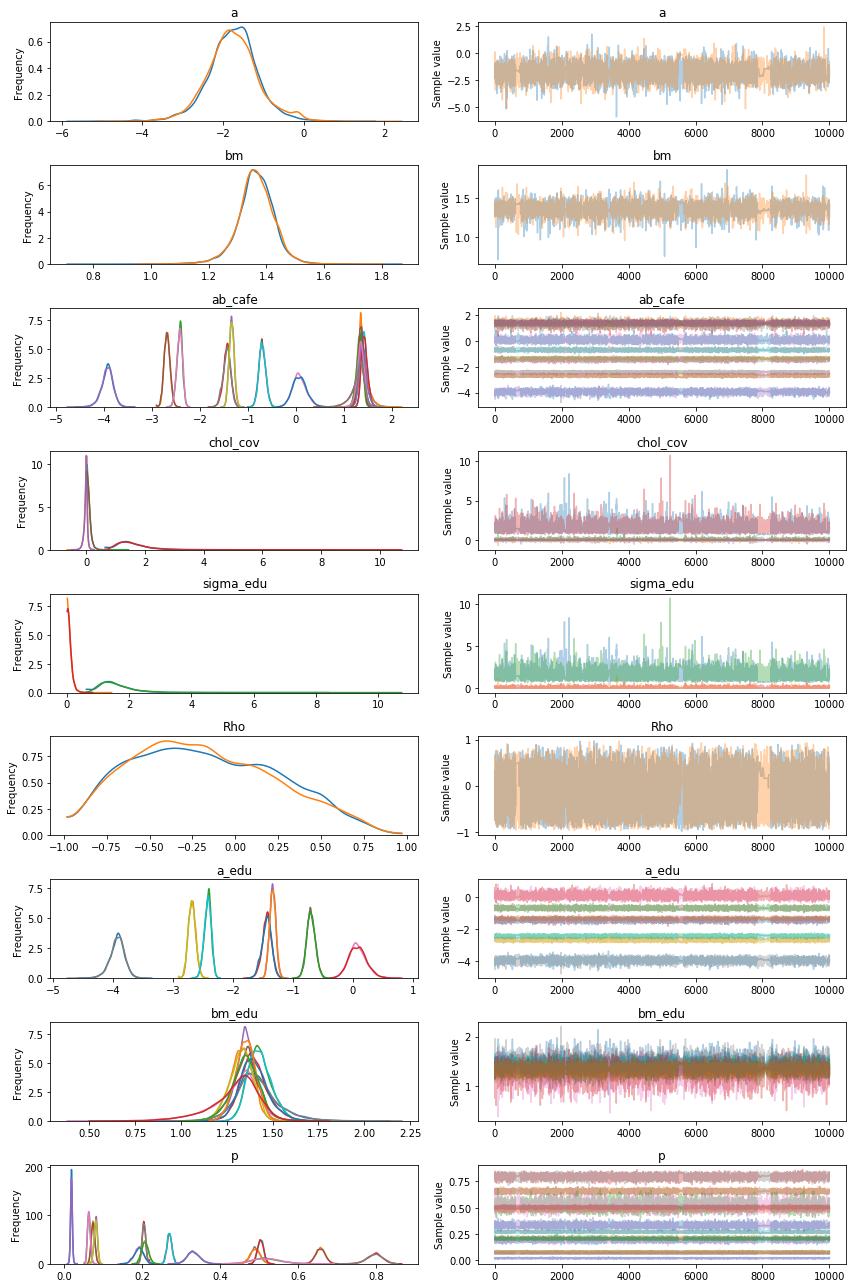

In [14]:
pm.traceplot(sample_B1);

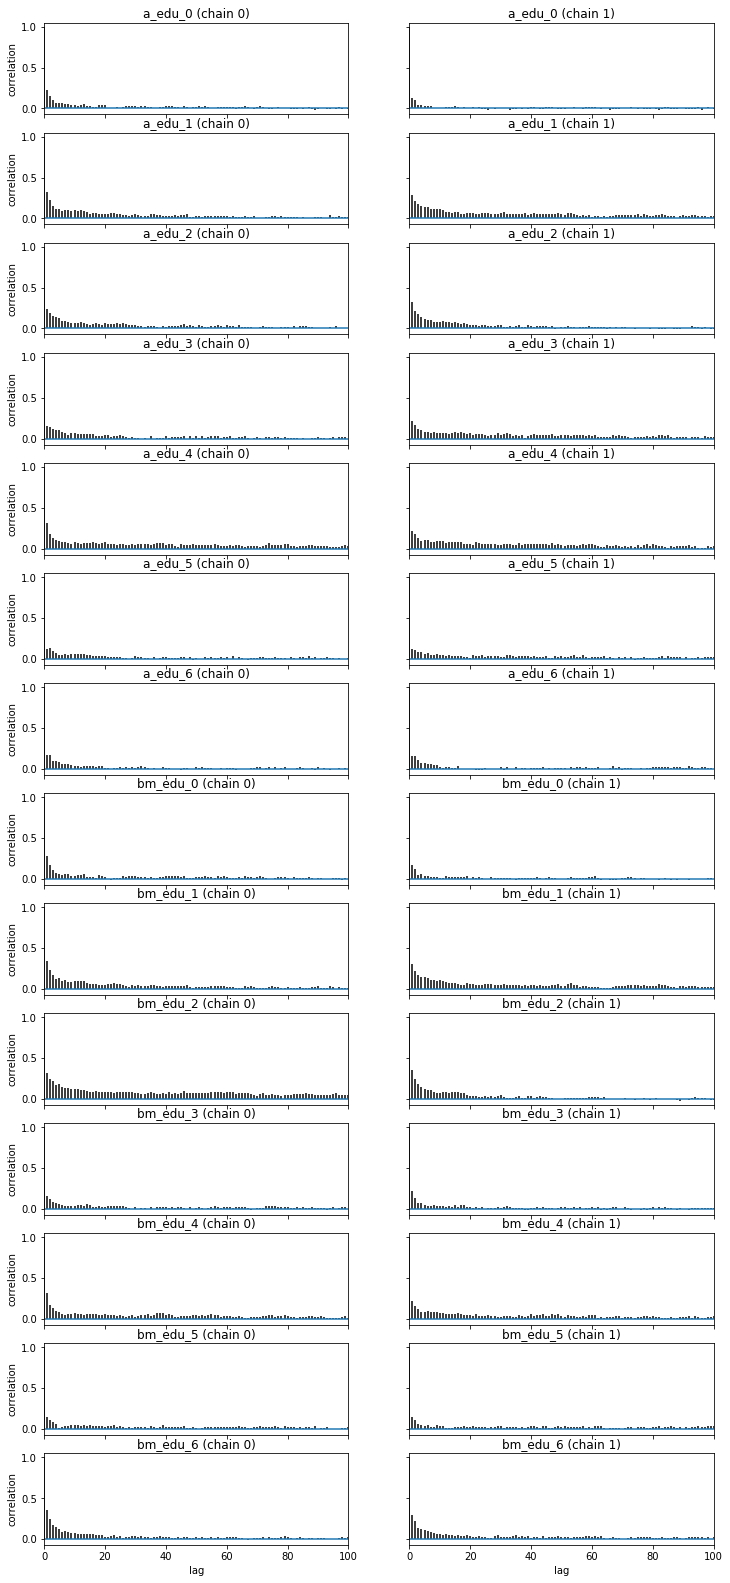

In [15]:
pm.autocorrplot(sample_B1,varnames=['a_edu','bm_edu']);

It seems the model doesn't converge well and there're a lot of autocorrelations. Let's further check Gelman statistic and the number of effective samples.

In [16]:
pm.diagnostics.gelman_rubin(sample_B1)

{'Rho': array([1.00006451]),
 'a': 1.000312659740586,
 'a_edu': array([0.99995893, 1.00009538, 1.00026901, 1.00036315, 0.99996333,
        0.99995003, 1.00007572]),
 'ab_cafe': array([[0.99995893, 0.99995002],
        [1.00009538, 0.9999551 ],
        [1.00026901, 1.00035769],
        [1.00036315, 1.00001295],
        [0.99996333, 0.99996753],
        [0.99995003, 0.99997409],
        [1.00007572, 0.99995243]]),
 'bm': 0.999951229285891,
 'bm_edu': array([0.99995002, 0.9999551 , 1.00035769, 1.00001295, 0.99996753,
        0.99997409, 0.99995243]),
 'chol_cov': array([1.0016643 , 0.99996734, 1.00007673]),
 'p': array([0.99995917, 0.9999728 , 1.00007242, 1.00038934, 1.00024951,
        1.00000985, 1.00033319, 1.0003294 , 0.99996088, 1.00013817,
        0.99995006, 0.99999893, 1.00007681, 1.00016254]),
 'sigma_edu': array([1.0016643 , 1.00001588])}

In [17]:
pm.diagnostics.effective_n(sample_B1)

{'Rho': array([1500.]),
 'a': 1524.0,
 'a_edu': array([5279., 1661., 2414., 2476., 1606., 4143., 6728.]),
 'ab_cafe': array([[5279., 4698.],
        [1661., 1858.],
        [2414., 1220.],
        [2476., 4597.],
        [1606., 2082.],
        [4143., 3399.],
        [6728., 2587.]]),
 'bm': 2180.0,
 'bm_edu': array([4698., 1858., 1220., 4597., 2082., 3399., 2587.]),
 'chol_cov': array([ 726., 5008., 1053.]),
 'p': array([5423., 2302., 1740., 2097., 2380.,  789., 2505., 3668., 1645.,
        3704., 4114., 5678., 6721., 2285.]),
 'sigma_edu': array([726., 991.])}

Our Gelman statistic is in a reasonable range (i.e. < 1.2). But the effective number of samples is awful (less than 10% for some parameters). And we have a lot of warnings from PyMC.

As a conclusion, the quality of the samples is bad.

**B3**: Propose at least two methods of improving the quality of the samples obtained and explain how/why each method would help. For **some extra credit** implement these. 

**Answer:**

**proposals: non-centered parameterization and smaller step size (higher `target_accept`)**

1.
Non-centered parameterization. It improves the sample quality because it reduces steepness and curvature, making for better stepping and it also reduces the strong change in densities, and makes sampling from the transition distribution easier (reference: [Lab 9](https://am207.github.io/2018spring/wiki/gelmanschoolstheory.html#an-equivalent-model-in-a-non-centered-parametrization)).

The implementation and model checking is below.

In [18]:
# Code 3.19 and 3.23
# of https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb
with pm.Model() as edu_B1_NC:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_edu', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    #Non-centered parameterization
    mu_chol_b = pm.Normal('mu_chol_b', 0., 1., shape=(7,2))
    mu = tt.stack([a,bm])+tt.dot(mu_chol_b,chol)
    
    pm.Deterministic('a_edu', mu[:, 0])
    pm.Deterministic('bm_edu', mu[:, 1])
    
    p = pm.Deterministic('p', pm.math.invlogit(mu[np.arange(14)//2,0] + mu[np.arange(14)//2,1] * x))
    y = pm.Binomial('y_obs', p=p, n=n, observed=y_obs)

    sample_B1_NC=pm.sample(10000,tune=3000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_chol_b, chol_cov_cholesky_cov_packed__, bm, a]
100%|██████████| 13000/13000 [12:11<00:00, 17.78it/s]
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


The warnings are less and the divergences are less, which are good. Let's check the convergence

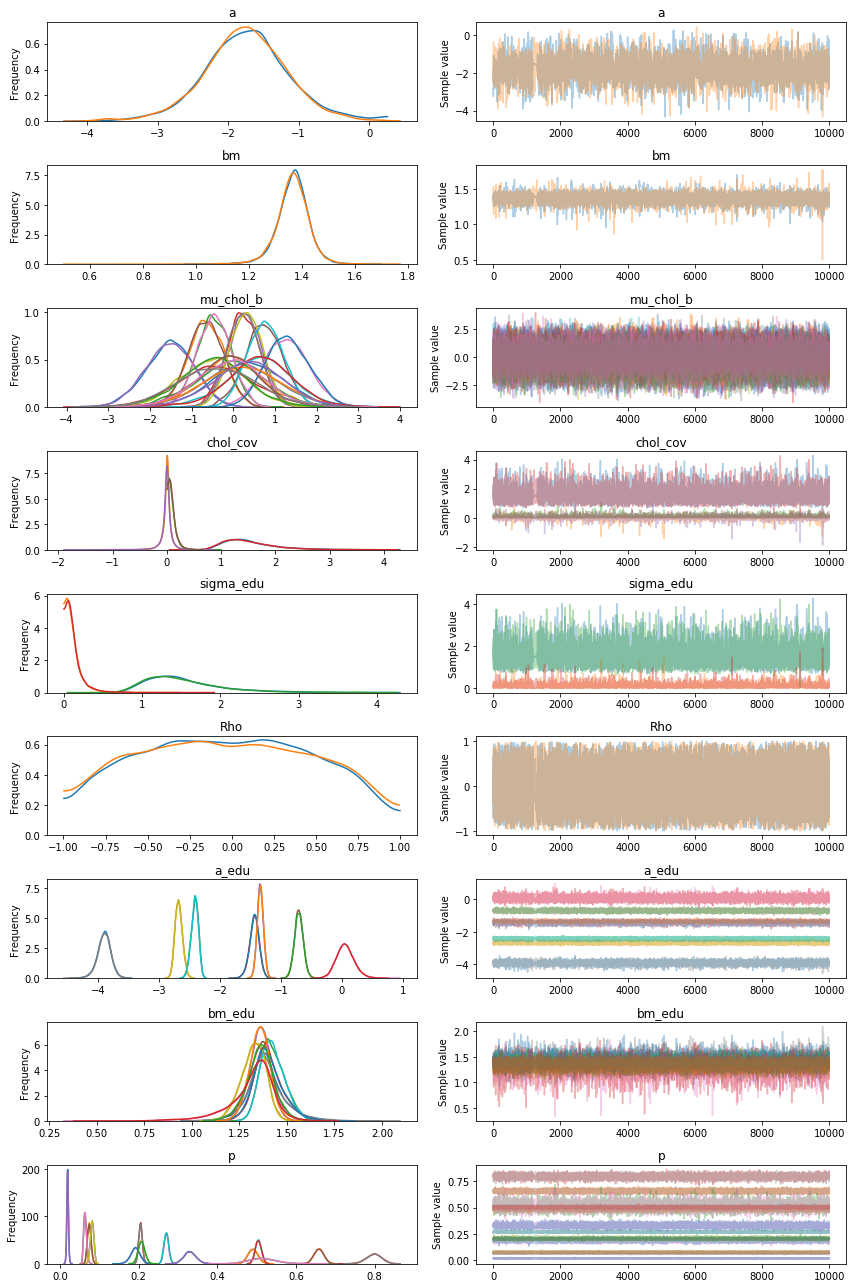

In [19]:
pm.traceplot(sample_B1_NC);

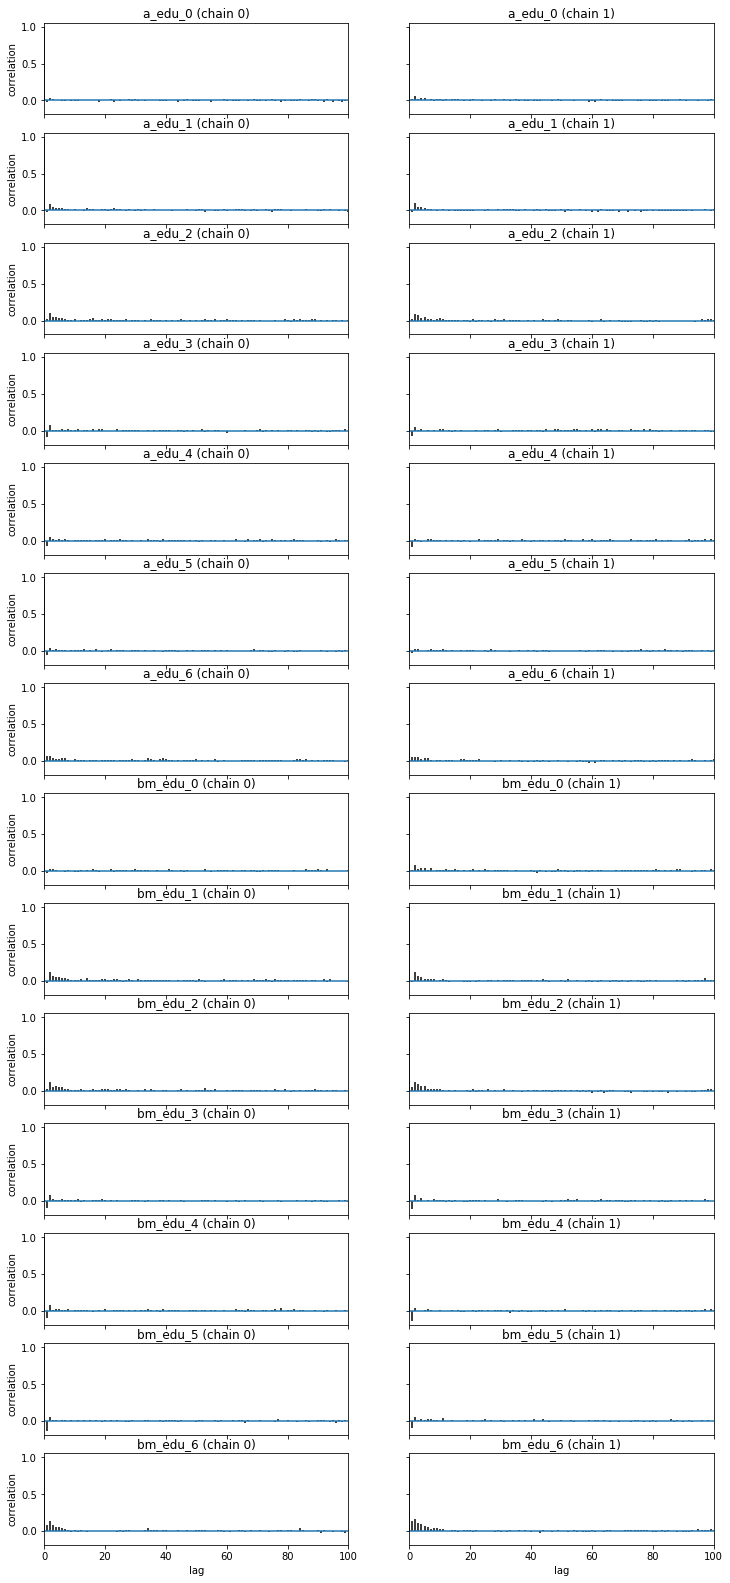

In [20]:
pm.autocorrplot(sample_B1_NC,varnames=['a_edu','bm_edu']);

In [21]:
pm.diagnostics.gelman_rubin(sample_B1_NC)

{'Rho': array([0.99997442]),
 'a': 1.0004968784132304,
 'a_edu': array([0.99995255, 1.00009796, 0.99997353, 0.99995042, 1.00001234,
        0.99996429, 0.99996716]),
 'bm': 0.9999557916672797,
 'bm_edu': array([0.99995667, 1.00022782, 0.99996208, 0.99995459, 0.99999055,
        0.99995821, 1.00009669]),
 'chol_cov': array([1.00026527, 1.0002431 , 1.00026488]),
 'mu_chol_b': array([[0.99997383, 0.99997743],
        [0.99995859, 1.00003478],
        [1.00000613, 0.99997717],
        [1.00027919, 0.99995706],
        [1.00034619, 1.00027161],
        [1.00054545, 1.0003252 ],
        [1.0004464 , 0.99999694]]),
 'p': array([0.99995002, 0.99995458, 1.00010356, 1.00008822, 0.9999773 ,
        0.9999547 , 0.99995049, 0.99996882, 1.00001063, 0.99995328,
        0.99996579, 0.99995081, 0.99996716, 0.99999548]),
 'sigma_edu': array([1.00026527, 1.00082969])}

In [22]:
pm.diagnostics.effective_n(sample_B1_NC)

{'Rho': array([14068.]),
 'a': 2703.0,
 'a_edu': array([15001., 12694.,  9674., 20000., 20000., 20000., 12493.]),
 'bm': 10786.0,
 'bm_edu': array([16007., 11208.,  8642., 20000., 20000., 20000.,  8946.]),
 'chol_cov': array([3753., 4224., 4048.]),
 'mu_chol_b': array([[ 3938., 15297.],
        [ 3412.,  8965.],
        [ 3256.,  9579.],
        [ 3078., 14403.],
        [ 3065.,  4023.],
        [ 3215.,  4844.],
        [ 3472., 20000.]]),
 'p': array([15355., 18145., 12755., 17625.,  9576., 17025., 20000., 17355.,
        20000., 20000., 20000., 20000., 12504., 16752.]),
 'sigma_edu': array([3753., 2409.])}

As expected, effective number statistic is better. However, it still does not look well.

2.
higher `target_accept` in addition to non-centered parameterization.

In [23]:
with edu_B1_NC:
    sample_B1_NC_high_ta=pm.sample(10000,tune=3000, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_chol_b, chol_cov_cholesky_cov_packed__, bm, a]
100%|██████████| 13000/13000 [11:46<00:00, 18.41it/s]
There were 341 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [24]:
pm.diagnostics.effective_n(sample_B1_NC_high_ta)

{'Rho': array([8335.]),
 'a': 1649.0,
 'a_edu': array([15725., 10594., 10790., 20000., 20000., 20000., 13191.]),
 'bm': 7028.0,
 'bm_edu': array([15529.,  9715.,  8976., 20000., 20000., 20000.,  8742.]),
 'chol_cov': array([ 236., 2986., 3289.]),
 'mu_chol_b': array([[ 1733., 16204.],
        [ 3366.,  2300.],
        [ 3267., 11681.],
        [ 2137., 20000.],
        [ 2057., 11028.],
        [ 1077., 15825.],
        [  876., 13012.]]),
 'p': array([16010., 19477., 10660., 17878., 10709., 17795., 20000., 17477.,
        20000., 20000., 20000., 20000., 13205., 16551.]),
 'sigma_edu': array([ 236., 2060.])}

Number of effective samples further improves.

**B4**: Regardless of your answer above, assume the samples are valid and give an analysis of whether the data and models support the hypothesis that males are more advantaged in lower income categories than they are in higher income categories. For full credit, include at least one formal model comparison or probability analysis.

**Answer:**

For B4 and B5, I use samples from non-centered parameterization model with high `target_accept` since this provides samples with best quality.

In [25]:
def make_compare(names, traces, models, ic='WAIC'):
    comparedf=pm.compare(traces,models, method='pseudo-BMA')
    temp=comparedf.sort_index()
    temp['Model']=names
    comparedf = temp.sort_values(ic).set_index('Model')
    return comparedf

names=['A1', 'B1']
dfc=make_compare(names, [sample_A1,sample_B1_NC_high_ta],[edu_A1,edu_B1_NC])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
B1,121.79,6.19,0,0.68,4.82,0,1
A1,123.27,6.12,1.48,0.32,5.67,1.57,1


The WAIC of the correlation included model is worse compared to the base model (in part A). Thus, the models and the data don't support the given hypothesis or there's no evidence that males are more advantaged in lower income categories.

**B5**: Regardless of your answer above, assume the samples are valid and give an analysis of: 
1. The posterior probability that males with a Bachelor's degree are more likely to have high incomes than males with a Professional School degree (education categories 3 and 4) \[Specifically, how certain is it that one or the other class has a higher chance of having a high income?\]. 
2. The posterior-predictive on the number of female PhDs earning more than 50K in similarly sized samples

**Answer:** For 1, we extract posterior samples of p(>50k) for both Bachelor male and Prof. School male (`id` is 9 and 7). Calculate the percentage of posterior samples where $p[9]>p[7]$.

For 2, we simply sample the posterior predictive (`sample_ppc`) and get the number of female PhDs earning more than 50K.

In [26]:
#1
print("The probability that male with Bachelor's degree are more likely to have high incomes:",
      np.mean(sample_B1_NC_high_ta.p[:,7]<sample_B1_NC_high_ta.p[:,9]))

The probability that male with Bachelor's degree are more likely to have high incomes: 0.82745


In [27]:
#2
with edu_B1_NC:
    ppc = pm.sample_ppc(sample_B1_NC_high_ta,samples=10000)
print("Posterior-predictive number for female PhDs earning more than 50K is",ppc['y_obs'][:,12].mean())

100%|██████████| 10000/10000 [00:05<00:00, 1932.37it/s]

Posterior-predictive number for female PhDs earning more than 50K is 44.2262


# Q2: Using Mixture of Experts and Mixture Density Networks to Solve Inverse Problems

What if you had to predict a one-to-many function? The data provided below comes from a dataset generated by Chris Bishop (yes that Bishop) to explain the models mentioned in the title above. We have included pdfs from his book which describe these models in some detail.

We read this data in...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df = pd.read_csv("one-to-many.csv")
df.head()

,target,x
0,0.000000,0.018727
1,0.001001,0.050424
2,0.002002,0.042375
3,0.003003,0.038596
4,0.004004,0.019352


...and then plot it. Notice both the uneven sampling (more towards the center), and the "more than one y" for a given x.

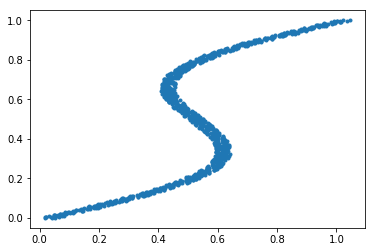

In [2]:
plt.plot(df.x, df.target, '.');

Normal regression approaches to modeling such a function wont work, as they expect the function to be a proper mathematical function, that is, single valued.

These kind of problems are called **inverse problems**, where more than one input state leads to an output state, and we have to try and model these multiple input states.

A mixture of gaussians (or other distributions) might is a sensible way to do this.

You choose one of the gaussians with some probability. The nean of the gaussian is then given by some regression function, say for example a straight line. We could additionally fix the standard deviation or model it as well. 

Thus, for each component Gaussian, we choose a functional form for the mean and standard deviation. So our model looks something like this:

$$f(x)  = \sum_i \lambda_i g_i (x) $$

Say we fit a model with 3 gaussians to this data. Such a model cannot fit the function above. Notice for example that at $x=0.2$ only one of the gaussians will dominate, different from the situation at $x=0.5$. This means that the probabilities of "belonging" to one or the other gaussians is also changing with $x$.

If we allow the mixing probabilities to depend on $x$, we can model this situation.

$$f(x)  = \sum_i \lambda_i (x) g_i (x) $$

Such a model is called a "mixture of experts" model. The idea is that one "expert" gaussian is responsible in one sector of the feature space, while another expert is responsible in another sector.

You can think of this model as implementing a "standard" gaussian mixture at each "point" x, with the added complexity that all of the means, standard deviations, and mixture probabilities change from one x to another.

See https://www.cs.toronto.edu/~hinton/absps/hme.pdf and http://www.ee.hacettepe.edu.tr/~eyuksel/Publications/2012_TwentyYearsofMixtureofExperts.pdf for more details. I found the latter clearer and easier to understand.

For this entire question you might find diagram code from [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb) useful. Take with attribution.

We will assume we have **3 gaussians**.

## PART A: Iterative Linear Regression

The basic idea, illustrated below, is to fit piecewise linear regressions iteratively in a EM style algorithm.

![](images/mixreg0.png)

The algorithm looks like this: initialize the 1000 points in this dataset as randomly belonging to one of 3 "classes" or "clusters" or "experts". This takes a x-data problem and augments it with a fake z data point that tells us whether the point belongs in cluster 0, 1, or 2. (It helps convergence to say that points in the leftmost 0.2 belong to cluster 0 and righmost 0.2 to cluster 2).

Once we have the fake z data we can separate out the 1000 points into 3 sets of points and fit 3 linear regression models. 

We can make predictions for all 1000 points on the data for each of the 3 regression lines. We now assign a data point to the cluster by calculating the squared distances between its actual y value and the 3 cluster predictions and choosing the smallest one.

We then rinse and repeat.

**A1** Implement this algorithm along with a convergence criterion of your choice

**A2** Produce a diagram like the one above which illustrates the straight line fits as well as the cluster belonging. 


**Answer:**

### A1

E-step: assign points to clusters.

M-step: re-calculate the regression lines.

I use sklearn to fit the OLS. The implementation is below. For initialization, I assign the leftmost 0.2 to cluster 0 and rightmost 0.2 to cluster2. All other points are assigned to cluster 1. As suggested in the problem, the leftmost 0.2 always belong to cluster 0 and the rightmost 0.2 always belong to cluster 2.

I set convergence criterion as **no point changes the cluster assignment from last iteration**.

In [3]:
from sklearn.linear_model import LinearRegression

def update_assignment(df,line_coef=None):
    assign_list = []
    for y,x in df.values:
        if x<0.2:
            assign_list.append(0)
        elif x>0.8:
            assign_list.append(2)
        else:
            if type(line_coef)==type(None):
                # initialize
                assign_list.append(1)
            else:
                y0 = line_coef[0]*x+line_coef[1]
                y1 = line_coef[2]*x+line_coef[3]
                y2 = line_coef[4]*x+line_coef[5]
                # get smallest cluster idx.
                assign_list.append(np.argmin(np.square(np.array([y0,y1,y2])-y)))
    return np.array(assign_list)
    
def make_clusters(points_assignment,df):
    clusters = [[],[],[]]
    for idx,(y,x) in enumerate(df.values):
        clusters[points_assignment[idx]].append([x,y])
    return clusters

def calc_regression(clusters):
    result = []
    for cluster in clusters:
        cluster = np.array(cluster)
        lr = LinearRegression()
        lr.fit(cluster[:,0].reshape(-1,1),cluster[:,1])
        result.append(lr.coef_[0])
        result.append(lr.intercept_)
    return np.array(result)

line_coef=None
old_assignment=None
while True:
    assignment = update_assignment(df,line_coef)
    # check convergence
    if all(assignment==old_assignment):
        break
    old_assignment=assignment
    clusters = make_clusters(assignment,df)
    line_coef = calc_regression(clusters)

### A2

The following graph shows the clustering assignment (different colors) and the straight line fits for points in each cluster.

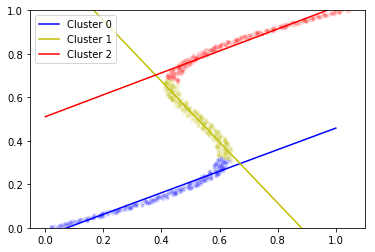

In [4]:
# plot cluster belongings
plt.scatter(np.array(clusters[0])[:,0],np.array(clusters[0])[:,1],c='b',marker='.',alpha=0.1)
plt.scatter(np.array(clusters[1])[:,0],np.array(clusters[1])[:,1],c='y',marker='.',alpha=0.1)
plt.scatter(np.array(clusters[2])[:,0],np.array(clusters[2])[:,1],c='r',marker='.',alpha=0.1)

#plot line
plot_x = np.linspace(0,1,100)
plt.plot(plot_x,line_coef[0]*plot_x+line_coef[1],color='b',label='Cluster 0')
plt.plot(plot_x,line_coef[2]*plot_x+line_coef[3],color='y',label='Cluster 1')
plt.plot(plot_x,line_coef[4]*plot_x+line_coef[5],color='r',label='Cluster 2')
plt.ylim((0,1))
plt.legend()
plt.show()

## Part B: Variational Mixture of Experts

In this part we'll construct a gaussian mixture model of 3 "expert" linear regressions. The idea is to create a fit which looks like this:

![](images/mixreg.png)

Here again the three regression lines work in different regions of $f$. We want a principled way to sample from this model and to be able to produce posterior and posterior-predictive regions.

There are 3 parts to this model. First the means of the gaussians in the mixture are modeled with linear regression as shown in the picture above. We will also model $log(\sigma)$ for each gaussian in the mixture as a linear regression as well ($\sigma$ needs to be positive).

We now need to model the mixture probabilities, i.e., the probabilities required to choose one or the other gaussian. We'll model these probabilities i.e. the $\lambda$s using softmax regression (ie do a linear regression and softmax it to get 3 probabilities).

**B1** Write a pymc3 model for this problem. For all biases and weights in your regressions, assume N(0,5) priors. Add noise 0.01 to each of the three $\sigma$s to make sure you dont have a collapsed 0 width gaussian, ie we want some data in every cluster. (Thus to get the final $\sigma$, you will exponentiate your regression for $log(\sigma)$ and add 0.01.)

**B2** Fit this model variationally for about 50,000 iterations using the adam optimizer. (`obj_optimizer=pm.adam()`) Plot the ELBO to make sure you have converged. Print summaries and traceplots for the means, $\sigma$s and probabilities.

**B3** Plot the mean posteriors with standard deviations against x. Also produce a diagram like the one above to show the means with standard deviations showing their uncertainty overlaid on the data.

**B4** Plot the posterior predictive (mean and variance) as a function of x for this model (using `sample_ppc` for example). Why does the posterior predictive look nothing like the data?

**B5** Make a "correct" posterior predictive diagram by taking into account which "cluster" or "regression line" the data is coming from. To do this you will need to sample using the softmax probabilities. A nice way to do this is "Gumbel softmax sampling". See http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/ for details. Color-code the predictive samples with the gaussian they came from. Superimpose the predictive on the original data. This diagram may look something like this:

![](images/mixpred.png)

**Answer:**
### B1
$$w_{\mu_{1,2,3}}, b_{\mu_{1,2,3}}\sim N(0,5)$$
$$w_{log(\sigma)_{1,2,3}}, b_{log(\sigma)_{1,2,3}} \sim N(0,5)$$
$$w_{\lambda_{1,2,3}}, b_{\lambda_{1,2,3}} \sim N(0,5)$$

In [32]:
x = df.x.values.reshape(-1,1)
y = df.target.values.reshape(-1,1)
ylen = np.prod(y.shape)
with pm.Model() as mixture_B1:
    w_mu = pm.Normal('w_mu', 0, 5, shape=(1,3))
    b_mu = pm.Normal('b_mu', 0, 5, shape=(1,3))
    w_sigma = pm.Normal('w_sigma', 0, 5, shape=(1,3))
    b_sigma = pm.Normal('b_sigma', 0, 5, shape=(1,3))
    w_lambda = pm.Normal('w_lambda', 0, 5, shape=(1,3))
    b_lambda = pm.Normal('b_lambda', 0, 5, shape=(1,3))
    sigma = pm.Deterministic('sigma',pm.math.exp(x*w_sigma+b_sigma)+0.01)
    mu = pm.Deterministic('mu',x*w_mu+b_mu)
    lambda_pre = x*w_lambda+b_lambda
    # softmax
    lambda_ = pm.Deterministic("lambda", tt.nnet.softmax(lambda_pre))
    y_obs = pm.NormalMixture("y_obs",w=lambda_,mu=mu,sd=sigma,observed=y)

### B2.

In [33]:
advifit = pm.ADVI(model=mixture_B1)
advifit.fit(50000,obj_optimizer=pm.adam())

Average Loss = -1,602.4: 100%|██████████| 50000/50000 [01:35<00:00, 524.55it/s]
Finished [100%]: Average Loss = -1,602.4


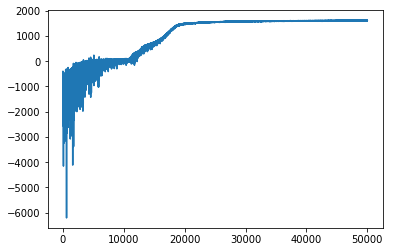

In [34]:
elbo = -advifit.hist
plt.plot(elbo);

From the ELBO, it seems the model has converged. Next we print summary and plot the trace.

In [35]:
trace = advifit.approx.sample(10000)

There will be too many traces if I plot all parameters. So I just print summary and plot trace for regression coefficients.

In [36]:
pm.summary(trace).head(18)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
w_mu__0_0,0.425551,0.000976,0.000009,0.423626,0.427441
w_mu__0_1,0.425818,0.002380,0.000024,0.421195,0.430482
w_mu__0_2,-1.592339,0.003855,0.000036,-1.599728,-1.584645
b_mu__0_0,0.574517,0.000796,0.000008,0.573008,0.576131
b_mu__0_1,-0.019945,0.000768,0.000007,-0.021473,-0.018460
b_mu__0_2,1.330681,0.002048,0.000022,1.326706,1.334593
w_sigma__0_0,-12.102955,0.216347,0.002198,-12.516279,-11.669172
w_sigma__0_1,10.048689,0.284293,0.003147,9.514065,10.616446
w_sigma__0_2,1.482411,0.111470,0.001214,1.271730,1.702832
b_sigma__0_0,1.751357,0.108787,0.001154,1.526360,1.953220


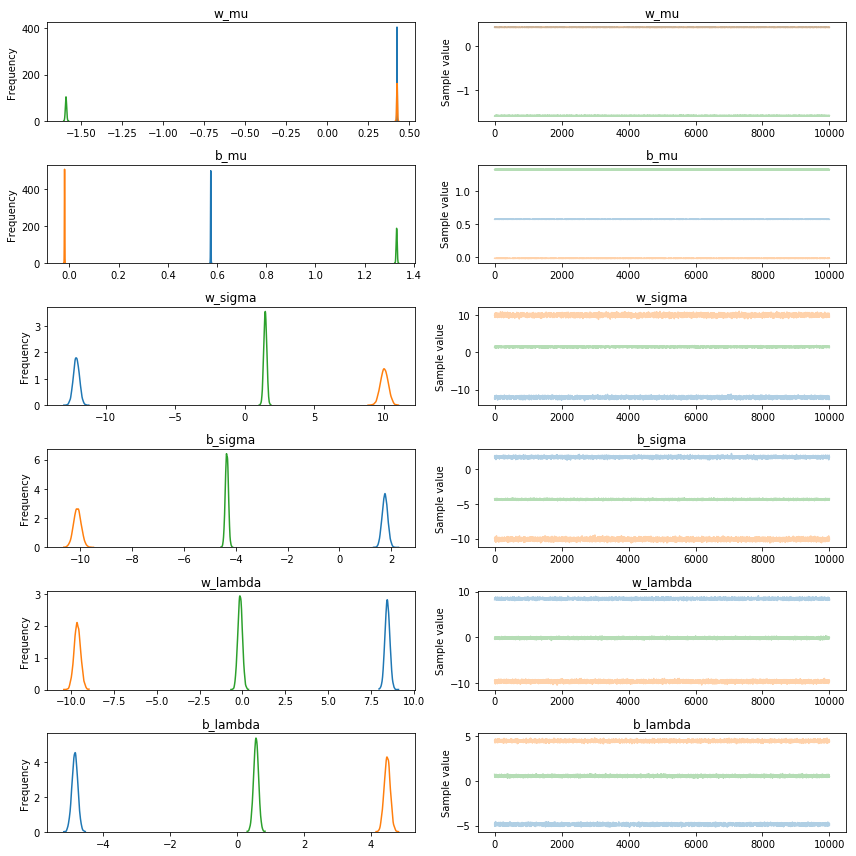

In [37]:
pm.traceplot(trace,varnames=['w_mu','b_mu','w_sigma','b_sigma','w_lambda','b_lambda']);

### B3

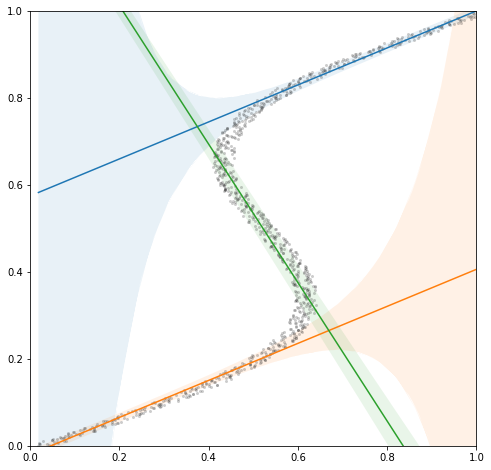

In [38]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(trace.mu.mean(axis=0).T, trace.sigma.mean(axis=0).T):
    plt.plot(x.reshape(-1,1), mu_k)
    plt.fill_between(x.reshape(-1), mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(x, y, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

This plot is similar to the given plot.

### B4

In [39]:
with mixture_B1:
    ppc = pm.sample_ppc(trace,samples=20000)

100%|██████████| 2000/2000 [00:58<00:00, 34.30it/s]


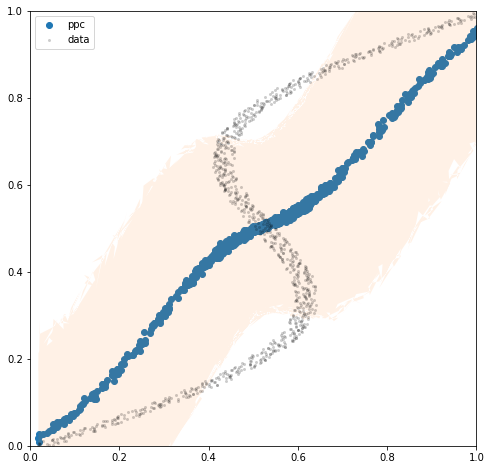

In [40]:
mean_ppc = ppc['y_obs'].mean(axis=0)
std_ppc = ppc['y_obs'].std(axis=0)
plt.figure(figsize=(8, 8), facecolor='white')
plt.scatter(x.reshape(-1,1), mean_ppc,label="ppc")
plt.fill_between(x.reshape(-1), mean_ppc-std_ppc, mean_ppc+std_ppc, alpha=0.1)
plt.scatter(x, y, marker='.', lw=0, alpha=0.2, c='black',label="data")
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.show()

The posterior predictive is not like the data because we only predict one value for each x. However, we have actually multiple values for an input.

### B5

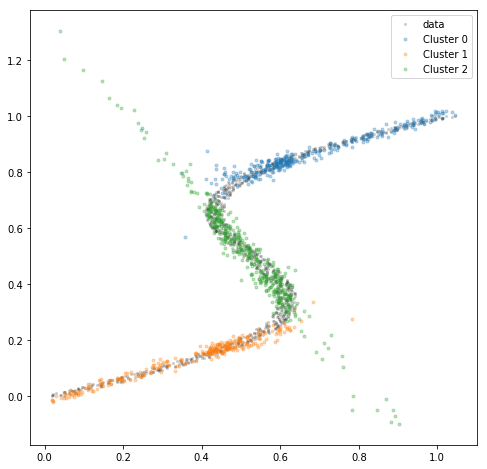

In [41]:
# Use Gumbel softmax sampling, code from 
# https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

plt.figure(figsize=(8, 8), facecolor='white')
category = gumbel_sample(trace['lambda'].mean(axis=0))
rn = np.random.randn(ylen)
sigma_mean = trace['sigma'].mean(axis=0)
mu_mean = trace['mu'].mean(axis=0)
plt.scatter(x, y, marker='.', lw=0, alpha=0.2, c='black',label="data")
for cluster in [0,1,2]:
    length = np.sum(category==cluster)
    ind = np.where(category==cluster)
    plt.scatter(x[ind],rn[ind] * sigma_mean[ind,cluster] + mu_mean[ind,cluster],
                marker='.',label="Cluster "+str(cluster),alpha=0.3)
plt.legend()
plt.show()

## Part C. Mixture Density Network

A mixture density network (see the enclosed Chapter 5 excerpt from Bishop or https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) is very closely related to the mixture of experts model. The difference is that we fit the regressions using a neural network where hidden layers are shared amongst the mean, sigma, and mixing probability regressions. (We could have fit 3 separate neural networks in Part A but opted to fit linear regressions for simplicity)

(More explanation [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb). You are welcome to take code from here with attribution.)

You job here is to construct a multi-layer perceptron model with a linear hidden layer with 20 units followed by a `Tanh` activation. After the activation layer, 3 separate linear layers with `n_hidden` inputs and `n_gaussian=3` outputs will complete the network. The probabilities part of the network is then passed through a softmax. The means part is left as is. The sigma part is exponentiated and 0.01 added, as in part A

Thus the structure looks like:

```
input:1 --linear-> n_hidden -> Tanh --linear-->n_gaussians      ...mu
                            --linear-->n_gaussians->softmax     ...lambda
                            --linear-->n_gaussians->exp + 0.01  ...sigma
```

We then need to use a loss function for the last layer of the network. 

Using the mean-squared-error loss is not appropriate as the expected value of samples drawn from the sampling distribution of the network will not reflect the 3-gaussian structure (this is the essence of the difference between B4 and B5 above). Thus we'll use the negative loss likelihood of the gaussian mixture model explicitly.

**C1**: Write the network as a class `MixtureDensityNetwork` which inherits from pytorch `nn.Module`. Implement a constructor which allows at-least the number of hidden layers to be varied. Also implement the `forward` method.

**C2**: Train the network using the Adam or similiar optimizer. Make sure your loss converges and plot this convergence.

**C3**: Plot the MLE parameters against x. Make a plot similar to B3 above where you overlay the "means" of the gaussians against the data.

**C4**: Sample from the sampling distributions to make a plot similar to B5 above

**To think about but not to hand in** What are the differences between a mixture density network and the mixture of experts. How do these differences translate to feature space? What would happen if we took the shared hidden layer nonlinearity (Tanh) out?

**Answer:**

### C1

In [42]:
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn 
from torch.autograd import Variable

# code below parially copied from 
# https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb
class MixtureDensityNetwork(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MixtureDensityNetwork, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_lambda = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_lambda(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h)) + 0.01
        mu = self.z_mu(z_h)
        return pi, sigma, mu

### C2

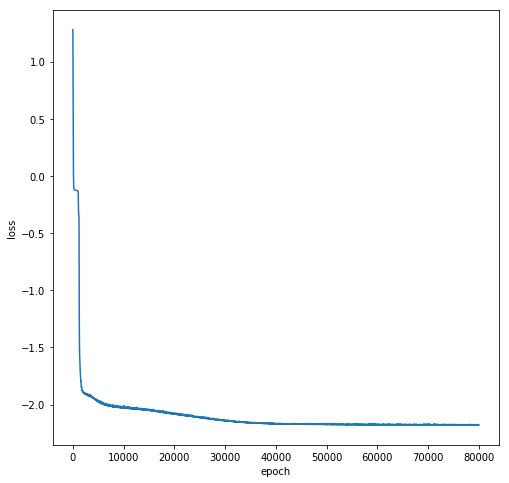

In [43]:
# code below parially copied from 
# https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)

network = MixtureDensityNetwork(n_hidden=20, n_gaussians=3)
optimizer = torch.optim.Adam(network.parameters())

x_variable = Variable(torch.FloatTensor(df.values[:,1].reshape(-1,1)))
y_variable = Variable(torch.FloatTensor(df.values[:,0].reshape(-1,1)), requires_grad=False)

def train_mdn(it=50000):
    losses = []
    for epoch in range(it):
        pi_variable, sigma_variable, mu_variable = network(x_variable)
        loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
    return losses

loss = train_mdn(it=80000)
plt.figure(figsize=(8, 8))
plt.plot(range(1,len(loss)+1),loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

The loss almost stops changing after iteration 50000. So we can say the loss converged.

### C3

First, plot MLE of parameters.

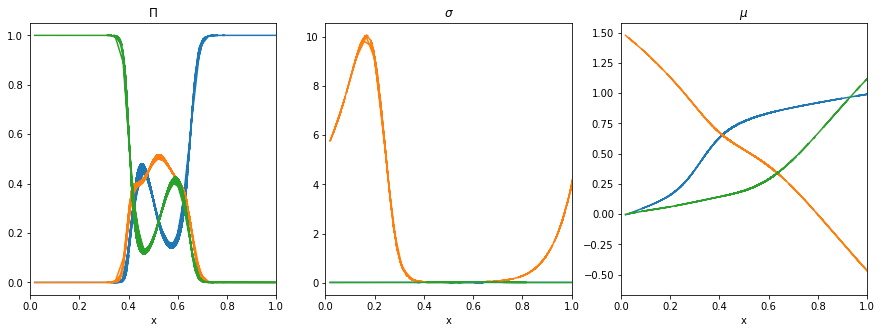

In [44]:
pi_variable, sigma_variable, mu_variable = network(x_variable)

pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(15,5))
ax1.plot(df.values[:,1].reshape(-1,1), pi_data)
ax1.set_title('$\Pi$')
ax2.plot(df.values[:,1].reshape(-1,1), sigma_data)
ax2.set_title('$\sigma$')
ax3.plot(df.values[:,1].reshape(-1,1), mu_data)
ax3.set_title('$\mu$')
plt.xlim([0,1])
ax1.set_xlabel('x')
ax2.set_xlabel('x')
ax3.set_xlabel('x')
plt.show()

Next, a plot similar to B3.

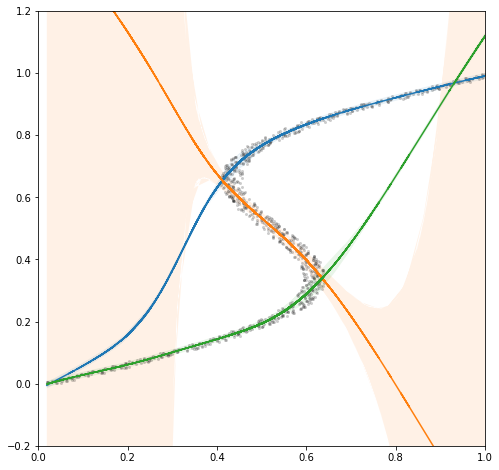

In [45]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(df.values[:,1].reshape(-1,1), mu_k)
    plt.fill_between(df.values[:,1], mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(df.values[:,1], df.values[:,0], marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([0,1])
plt.ylim([-0.2,1.2])
plt.show()

### C4

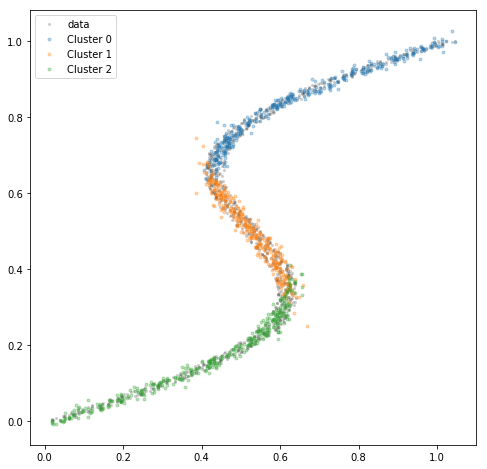

In [46]:
# Use Gumbel softmax sampling, code from 
# https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

plt.figure(figsize=(8, 8), facecolor='white')
category = gumbel_sample(pi_data)
rn = np.random.randn(ylen)
plt.scatter(x, y, marker='.', lw=0, alpha=0.2, c='black',label="data")
for cluster in [0,1,2]:
    length = np.sum(category==cluster)
    ind = np.where(category==cluster)
    plt.scatter(x[ind],rn[ind] * sigma_data[ind,cluster] + mu_data[ind,cluster],
                marker='.',label="Cluster "+str(cluster),alpha=0.3)
plt.legend()
plt.show()

## Part D Variational Mixture Density Network

We want to implement the Mixture Density Metwork model that we constructed in Part C in directly in pymc3 and use variational inference to sample from it. We  may need more iterations in order to get convergence as this model will likely not converge as fast as the pytorch equivalent.

**D1**: Write out the equivalent pymc3 version of the MDN and generate posterior samples with ADVI.

**D2**: Sample from the posterior predictive as you did in B4 and produce a diagram like C4 and B5 for this model.

**D3**: Plot the "mean" regression curves (similar to C3 and B3). Do the "mean" regression curves in this model look the same from those in Part C?  If they differ why so?

**Answer:**

### D1

From my experiment, PyMC variational fit often goes to local minimum. If it happens, please retry.

In [47]:
with pm.Model() as MDN_D1:
    w_common = pm.Normal("w_common",0,5,shape=(1,20))
    b_common = pm.Normal('b_common',0,5,shape=(1,20))
    
    # size = -1 * 20
    common_hidden = pm.math.tanh(tt.dot(x,w_common)+b_common)
    
    w_mu = pm.Normal('w_mu', 0, 5, shape=(20,3))
    b_mu = pm.Normal('b_mu', 0, 5, shape=(1,3))
    w_sigma = pm.Normal('w_sigma', 0, 5, shape=(20,3))
    b_sigma = pm.Normal('b_sigma', 0, 5, shape=(1,3))
    w_lambda = pm.Normal('w_lambda', 0, 5, shape=(20,3))
    b_lambda = pm.Normal('b_lambda', 0, 5, shape=(1,3))
    
    # size = -1 * 3
    sigma = pm.Deterministic('sigma',pm.math.exp(tt.dot(common_hidden,w_sigma)+b_sigma)+0.01)
    mu = pm.Deterministic('mu',tt.dot(common_hidden,w_mu)+b_mu)
    lambda_pre = tt.dot(common_hidden,w_lambda)+b_lambda
    
    # softmax
    lambda_ = pm.Deterministic("lambda", tt.nnet.softmax(lambda_pre))
    y_obs = pm.NormalMixture("y_obs",w=lambda_,mu=mu,sd=sigma,observed=y)

In [48]:
advifit = pm.ADVI(model=MDN_D1)
advifit.fit(100000,obj_optimizer=pm.adam(learning_rate=3e-3))

Average Loss = -1,262.6: 100%|██████████| 100000/100000 [05:46<00:00, 288.43it/s]
Finished [100%]: Average Loss = -1,262.4


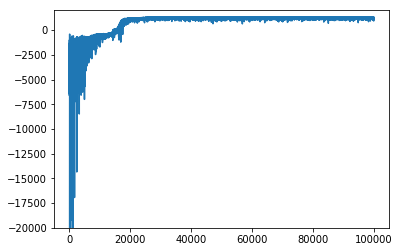

In [49]:
elbo = -advifit.hist
plt.ylim(-20000,2000)
plt.plot(elbo);

From ELBO, the model has converged. Let's get 10000 posterior samples.

In [50]:
trace_D = advifit.approx.sample(10000)

### D2

First do posterior predictive like B4.

In [51]:
with MDN_D1:
    ppc_D = pm.sample_ppc(trace_D,samples=20000)

100%|██████████| 2000/2000 [01:00<00:00, 32.95it/s]


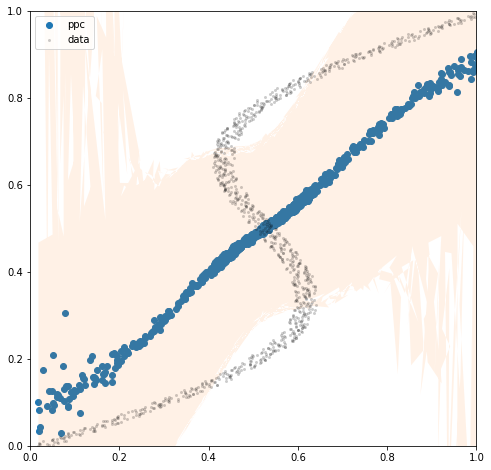

In [52]:
mean_ppc = ppc_D['y_obs'].mean(axis=0)
std_ppc = ppc_D['y_obs'].std(axis=0)
plt.figure(figsize=(8, 8), facecolor='white')
plt.scatter(x.reshape(-1,1), mean_ppc,label="ppc")
plt.fill_between(x.reshape(-1), mean_ppc-std_ppc, mean_ppc+std_ppc, alpha=0.1)
plt.scatter(x, y, marker='.', lw=0, alpha=0.2, c='black',label="data")
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.show()

Next, generate diagram like  C4 and B5.

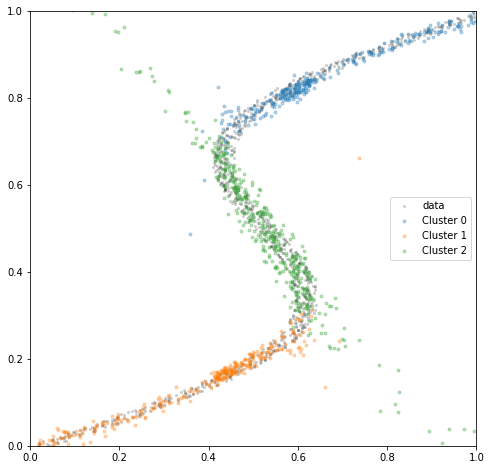

In [53]:
# Use Gumbel softmax sampling, code from 
# https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

plt.figure(figsize=(8, 8), facecolor='white')
category = gumbel_sample(trace_D['lambda'].mean(axis=0))
rn = np.random.randn(ylen)
sigma_mean = trace_D['sigma'].mean(axis=0)
mu_mean = trace_D['mu'].mean(axis=0)
plt.scatter(x, y, marker='.', lw=0, alpha=0.2, c='black',label="data")
for cluster in [0,1,2]:
    length = np.sum(category==cluster)
    ind = np.where(category==cluster)
    plt.scatter(x[ind],rn[ind] * sigma_mean[ind,cluster] + mu_mean[ind,cluster],
                marker='.',label="Cluster "+str(cluster),alpha=0.3)
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

### D3

Next, plot the mean regression curve.

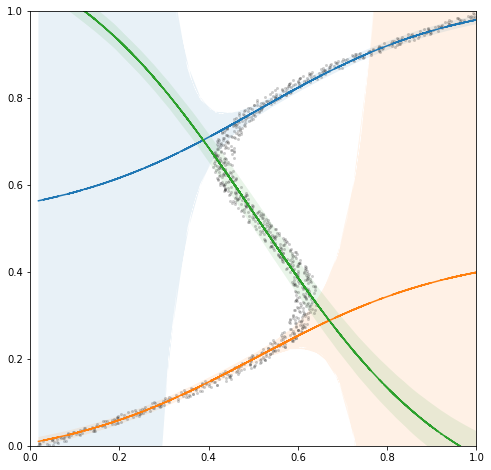

In [54]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(trace_D.mu.mean(axis=0).T, trace_D.sigma.mean(axis=0).T):
    plt.plot(x.reshape(-1,1), mu_k)
    plt.fill_between(x.reshape(-1), mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(x, y, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

They differ. Models in this plot shows more variance in areas where other experts dominate. The reason is that this model takes prior into consideration.

## Part E: Approximate EM for model in part B (EXTRA CREDIT)

Part B can be implemented using Expectation Maximization using iteratively-reweighted least squares. Our method in A was merely an approximation to this process. You can find update equations [here](https://people.eecs.berkeley.edu/~jordan/papers/jordan-xu.ps)

**Answer:** 

I use algorithm 1 at the beginning of page 12 of the attached paper *Convergence results for the EM approach to
mixtures of experts architectures*.

The E-step is to calculate $h_j$ (equation 15 in the paper) while the M-step is to update `w_mu`, `b_mu`, `sigma`, `w_lambda` and `b_lambda` as in B (note, the paper simplify the $\sigma$ calculations by setting it a single value for each expert). `w_mu` and `b_mu` correspond to $\mathbf{\theta}_j$ (equation 21) in the paper. `sigma` corresponds to $\Sigma$ in the paper (equation 19) and `w_lambda`, `b_lambda` correspond to $\mathbf{\theta}_0$ in the paper (equation 27).

Similar as A, to help convergence, I set points with $x \in [0,0.2)$ with weights $(1,0,0)$ (belongs to cluster 0) and points with $x \in (0.8,1]$ with weights $(0,0,1)$. This can be done by setting a very big number (`1e5`) for cluster 0 or cluster 2 weight. To avoid numerical overflow, I always add 0.01 to `sigma` like in part C.

In [55]:
from scipy.stats import norm
import copy

# initialize... The initialization works because we hardly set 0-0.2 x to cluster 0 and 0.8-1 x to cluster 2
params_dict = {'w_mu':[0.1,0.1,0.1],'b_mu':[0.1,0.1,0.1],'sigma':[1,1,1],
               'w_lambda':[0.1,0.1,0.1],'b_lambda':[0.1,0.1,0.1]}
for k in params_dict.keys():
    params_dict[k]=np.array(params_dict[k]).reshape(1,-1)
    
# return h
def calc_e_step(params_dict,x,y):
    
    # gate
    lambda_g = x.dot(params_dict['w_lambda'])+params_dict['b_lambda']
    
    # to help convergence
    lambda_g[(x<0.2).reshape(-1),0]=1e5
    lambda_g[(x>0.8).reshape(-1),2]=1e5

    #softmax
    lambda_g = np.exp(lambda_g - np.max(lambda_g,axis=1).reshape(-1,1))
    lambda_g = lambda_g / lambda_g.sum(axis=1).reshape(-1,1)
    
    for i in range(1000):
        for j in range(3):
            lambda_g[i,j] *= norm.pdf(y[i], loc=params_dict['w_mu'][0,j]*x[i]+params_dict['b_mu'][0,j],
                                scale=params_dict['sigma'][0,j])
    # return h_j(t)
    return lambda_g / lambda_g.sum(axis=1).reshape(-1,1)

def calc_m_step(params_dict,x,y,h,lr = 0.01):
    new_params = copy.deepcopy(params_dict)
    # update sigma
    
    # calculate mu based on last params (f_j in paper)
    fjx = x.dot(params_dict['w_mu'])+params_dict['b_mu']
    y_minus_fjx = y - fjx
    y_minus_fjx_sqr = np.square(y_minus_fjx)
    numerator = np.sum(h * y_minus_fjx_sqr,axis=0)
    denominator = np.sum(h,axis=0)
    new_params['sigma'] = (numerator / denominator).reshape(1,-1)+0.01
    
    # update lambda
    
    # gate, shape 1000*3
    lambda_g = x.dot(params_dict['w_lambda'])+params_dict['b_lambda']
    
    #softmax
    lambda_g = np.exp(lambda_g - np.max(lambda_g,axis=1).reshape(-1,1))
    lambda_g = lambda_g / lambda_g.sum(axis=1).reshape(-1,1)
    
    
    # shape 6*1
    eg = np.zeros((6,1))
    # shape 6*6
    Rg = np.zeros((6,6))
    
    theta0_old = np.array(list(zip(params_dict['w_lambda'].reshape(-1),params_dict['b_lambda'].reshape(-1))
                              )).flatten()
    
    # To speedup, merge eg, Rg calculation with Rj for mu update.
    
    # update mu
    Rj = [np.array([[0.,0.],[0.,0.]]),np.array([[0.,0.],[0.,0.]]),np.array([[0.,0.],[0.,0.]])]
    cj = np.array([[0.,0.,0.],[0.,0.,0.]])
    for ind, (x_t,y_t) in enumerate(zip(x.flatten(),y.flatten())):
        Xt = np.array([[x_t],[1.0]])
        # cj shape 2*3
        cj += (Xt*y_t).dot(h[ind].reshape(1,-1)) / params_dict['sigma']
        for j in [0,1,2]:
            design_mtx = np.zeros((6,1))
            design_mtx[2*j,0] = x_t
            design_mtx[2*j+1,0] = 1.0
            # shape 6*1
            eg += (h[ind,j]-lambda_g[ind,j])*design_mtx
            # shape 6*6
            Rg += lambda_g[ind,j] * (1-lambda_g[ind,j]) * design_mtx.dot(design_mtx.T)
            Rj[j] += (h[ind,j]*Xt / params_dict['sigma'][0,j]).dot(Xt.T)
            
    # IRLS
    # shape (6,1)
    theta0_new = theta0_old.reshape(-1,1)+lr*np.linalg.inv(Rg+1e-5).dot(eg)
    
    for j in [0,1,2]:
        # shape 2
        new_params['w_mu'][0,j], new_params['b_mu'][0,j] = np.linalg.inv(Rj[j]+1e-5).dot(
            cj[:,j].reshape(-1,1)).reshape(-1)
    
        new_params['w_lambda'][0,j] = theta0_new[2*j,0]
        new_params['b_lambda'][0,j] = theta0_new[2*j+1,0]
    
    return new_params

Let's do EM. The learning rate for $\mathbf{\theta}_0$ is set to 0.01 and the convergence criterion is set to
$$max\left(\left(\text{new_params} - \text{old_params}\right)^2\right)\leq 0.001$$

To avoid a too-early termination, I also set iteration criterion to
$$\text{iteration}> 500$$

In [56]:
x = df.x.values.reshape(-1,1)
y = df.target.values.reshape(-1,1)
maxdiff = 1000
it=0
# Do EM
while maxdiff > 1e-3 or it<500:
    it+=1
    h = calc_e_step(params_dict,x,y)
    new_params = calc_m_step(params_dict,x,y,h)
    maxdiff = np.max([np.square(new_params[i] - params_dict[i]).max() for i in params_dict.keys()])
    params_dict=new_params

Generate a plot like B3 for regression line and the standard deviation.

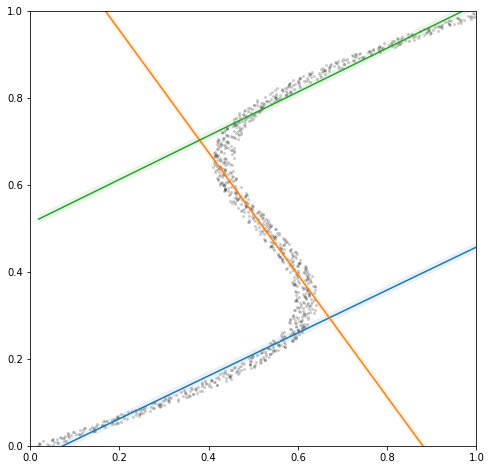

In [57]:
plt.figure(figsize=(8, 8), facecolor='white')
for ind, mu_k in enumerate((x.dot(params_dict['w_mu'])+params_dict['b_mu']).T):
    plt.plot(x.reshape(-1,1), mu_k)
    plt.fill_between(x.reshape(-1), mu_k-params_dict['sigma'][0,ind], mu_k+params_dict['sigma'][0,ind], alpha=0.1)
plt.scatter(x, y, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

Next, generate a sampling plot like B5.

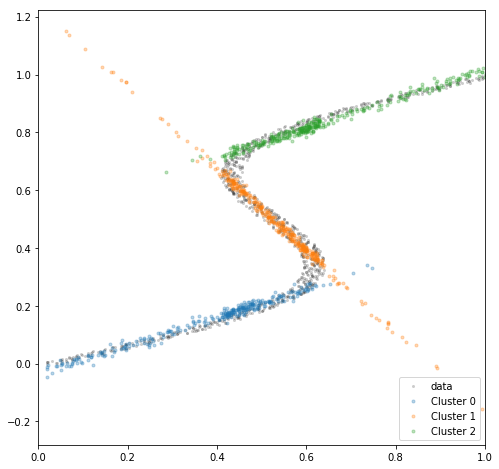

In [58]:
# Use Gumbel softmax sampling, code from 
# https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

plt.figure(figsize=(8, 8), facecolor='white')
lambda_g = x.dot(params_dict['w_lambda'])+params_dict['b_lambda']
# softmax
lambda_g = np.exp(lambda_g - np.max(lambda_g,axis=1).reshape(-1,1))
lambda_g = lambda_g / lambda_g.sum(axis=1).reshape(-1,1)
category = gumbel_sample(lambda_g)
rn = np.random.randn(np.prod(x.shape))
sigma = params_dict['sigma'].reshape(-1)
mu = x.dot(params_dict['w_mu'])+params_dict['b_mu']
plt.scatter(x, y, marker='.', lw=0, alpha=0.2, c='black',label="data")
for cluster in [0,1,2]:
    length = np.sum(category==cluster)
    ind = np.where(category==cluster)
    plt.scatter(x[ind],rn[ind] * sigma[cluster] + mu[ind,cluster],
                marker='.',label="Cluster "+str(cluster),alpha=0.3)
plt.legend()
plt.xlim(0,1)
#plt.ylim(0,1)
plt.show()

The plots are pretty simiar to those in part B instead we are now having single $\sigma$ for each expert so the $\sigma$ is small.

Visually, my result is correct.